Found 28804 validated image filenames belonging to 2 classes.
Found 7200 validated image filenames belonging to 2 classes.
Found 4001 validated image filenames belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
-------Training Full Dataset-------
Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734539891.842795      69 service.cc:145] XLA service 0x7e5d14002150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734539891.842885      69 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734539891.842892      69 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/451 ━━━━━━━━━━━━━━━━━━━━ 2:29:24 20s/step - accuracy: 0.4844 - loss: 0.7472 - precision: 0.4844 - recall: 0.4844

I0000 00:00:1734539901.014311      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


451/451 ━━━━━━━━━━━━━━━━━━━━ 302s 627ms/step - accuracy: 0.6714 - loss: 0.6129 - precision: 0.6714 - recall: 0.6714 - val_accuracy: 0.7457 - val_loss: 0.5272 - val_precision: 0.7457 - val_recall: 0.7457
Epoch 2/25
451/451 ━━━━━━━━━━━━━━━━━━━━ 280s 614ms/step - accuracy: 0.7445 - loss: 0.5273 - precision: 0.7445 - recall: 0.7445 - val_accuracy: 0.7561 - val_loss: 0.5163 - val_precision: 0.7561 - val_recall: 0.7561
Epoch 3/25
451/451 ━━━━━━━━━━━━━━━━━━━━ 283s 619ms/step - accuracy: 0.7627 - loss: 0.5015 - precision: 0.7627 - recall: 0.7627 - val_accuracy: 0.7699 - val_loss: 0.4958 - val_precision: 0.7699 - val_recall: 0.7699
Epoch 4/25
451/451 ━━━━━━━━━━━━━━━━━━━━ 278s 608ms/step - accuracy: 0.7723 - loss: 0.4864 - precision: 0.7723 - recall: 0.7723 - val_accuracy: 0.7746 - val_loss: 0.4898 - val_precision: 0.7746 - val_recall: 0.7746
Epoch 5/25
451/451 ━━━━━━━━━━━━━━━━━━━━ 279s 611ms/step - accuracy: 0.7772 - loss: 0.4799 - precision: 0.7772 - recall: 0.7772 - val_accuracy: 0.7785 - val

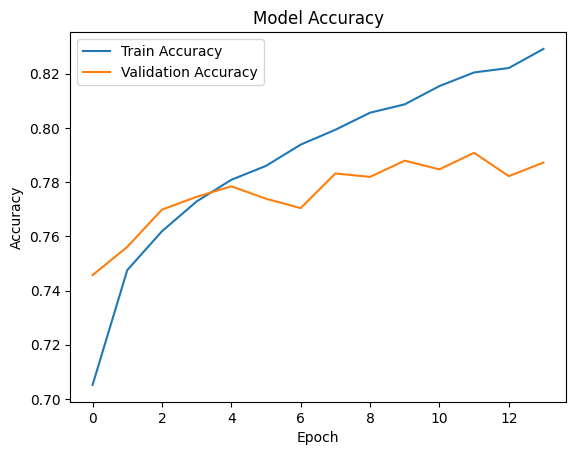

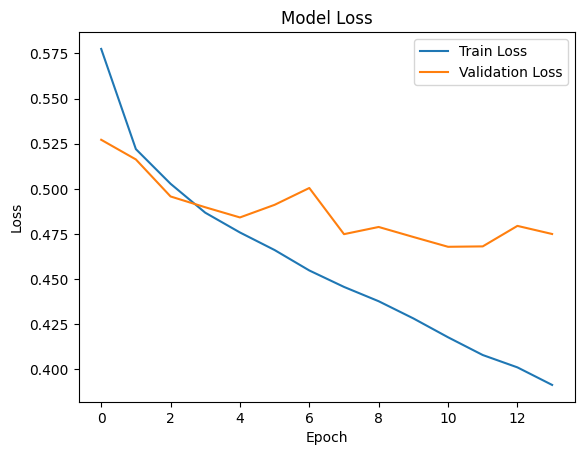

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from PIL import Image, UnidentifiedImageError

# Hàm kiểm tra file ảnh hợp lệ
def is_valid_image(filepath):
    try:
        with Image.open(filepath) as img:
            img.verify()
        return True
    except (UnidentifiedImageError, IOError):
        return False

# Hàm load toàn bộ dataset
def load_full_dataset(path):
    """
    Load toàn bộ X-ray dataset
    """
    dataset = []
    for folder in os.listdir(path):  # train/test
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for body_part in os.listdir(folder_path): 
                part_path = os.path.join(folder_path, body_part)
                if os.path.isdir(part_path):
                    for patient_id in os.listdir(part_path):  
                        patient_path = os.path.join(part_path, patient_id)
                        for lab in os.listdir(patient_path):  
                            if lab.split('_')[-1] == 'positive':
                                label = 'fractured'
                            elif lab.split('_')[-1] == 'negative':
                                label = 'normal'
                            lab_path = os.path.join(patient_path, lab)
                            for img in os.listdir(lab_path):
                                img_path = os.path.join(lab_path, img)
                                
                                if is_valid_image(img_path):
                                    dataset.append({
                                        'body_part': body_part,
                                        'patient_id': patient_id,
                                        'label': label,
                                        'image_path': img_path
                                    })
    return dataset

# Hàm huấn luyện mô hình
def train_model():
    image_dir = '/kaggle/input/mura-dataset/MURA-v1.1'
    data = load_full_dataset(image_dir)
    labels = []
    filepaths = []

    # Chuẩn bị dữ liệu
    for row in data:
        labels.append(row['label'])
        filepaths.append(row['image_path'])

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    images = pd.concat([filepaths, labels], axis=1)

    train_df, test_df = train_test_split(images, train_size=0.9, shuffle=True, random_state=1)

    # Tạo DataGenerator
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        horizontal_flip=True,
        preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
        validation_split=0.2
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.resnet50.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=True,
        seed=42,
        subset='training'
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=64,
        shuffle=True,
        seed=42,
        subset='validation'
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    # Tạo mô hình sử dụng ResNet50
    pretrained_model = tf.keras.applications.resnet50.ResNet50(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )

    pretrained_model.trainable = False

    inputs = pretrained_model.input
    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(50, activation='relu')(x)
    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    print("-------Training Full Dataset-------")
    model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', 
             Precision(name='precision'),
             Recall(name='recall')]
)

    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(train_images, validation_data=val_images, epochs=25, callbacks=[callbacks])

    # Lưu mô hình
    THIS_FOLDER = '/kaggle/working'
    model.save(THIS_FOLDER + "/weights/ResNet50_full_frac.h5")

    # Đánh giá trên test set
    results = model.evaluate(test_images, verbose=0)
    print("Full Dataset Results:")
    print(f"Test Loss: {results[0]}")
    print(f"Test Accuracy: {results[1] * 100}%")
    print(f"Test Precision: {results[2] * 100}%")
    print(f"Test Recall: {results[3] * 100}%")  # In ra Recall

    # Vẽ và lưu các biểu đồ
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    train_model()
